In [ ]:
Questions:
    1. See below 

In [2]:
#read in Json data file

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import io 
import seaborn as sns
import seaborn as sn

import datetime

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier, cv, plot_importance


user_login = pd.read_json('ultimate_data_challenge.json')
login_times = pd.read_json('logins.json')

# Part 1 ‑ Exploratory Data Analysis


In [6]:
#check head of data

user_login.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [7]:
#check info of data

user_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


almost %15 of the drivers ratings are missing we want to fill in those null values

In [23]:
user_login.last_trip_date = pd.to_datetime(user_login.last_trip_date)
user_login.signup_date = pd.to_datetime(user_login.signup_date)

In [24]:
user_login.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
#check head of data

login_times.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#check info of data

login_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


- Aggregate these login counts based on 15 minute time intervals 
- visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 
- Report/illustrate important features of the demand, such as daily cycles
- If there are data quality issues, please report them

In [14]:
login_times.min(), login_times.max()

(login_time     1970-01-01 20:12:16
 login_count                     15
 dtype: object, login_time     1970-04-13 18:57:38
 login_count                     15
 dtype: object)

In [8]:
sorted = login_times.sort_values(by= 'login_time')

In [9]:
sorted.head(10)

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
5,1970-01-01 20:21:41
10,1970-01-01 20:26:05
4,1970-01-01 20:26:21
11,1970-01-01 20:31:03
12,1970-01-01 20:34:46


In [10]:
sorted_times = pd.DataFrame(sorted.resample('15T', on='login_time').size(), columns=['count'])

In [28]:
print(sorted_times)

                     count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1
...                    ...
1970-04-13 17:45:00      5
1970-04-13 18:00:00      5
1970-04-13 18:15:00      2
1970-04-13 18:30:00      7
1970-04-13 18:45:00      6

[9788 rows x 1 columns]


In [11]:
# Converting the index as datetime
#login_times.index = pd.to_datetime(login_times.index)

#Group timestamps by 15 min
#login_times.groupby(pd.Grouper(freq="15Min")).sum()

#set index to login_time
#index_login_times= login_times.set_index("login_time")

#print(index_login_times)  

                     login_count
login_time                      
1970-01-01 20:13:18           15
1970-01-01 20:16:10           15
1970-01-01 20:16:37           15
1970-01-01 20:16:36           15
1970-01-01 20:26:21           15
...                          ...
1970-04-13 18:50:19           15
1970-04-13 18:43:56           15
1970-04-13 18:54:02           15
1970-04-13 18:57:38           15
1970-04-13 18:54:23           15

[93142 rows x 1 columns]


Plot new data

NameError: name 'mdates' is not defined

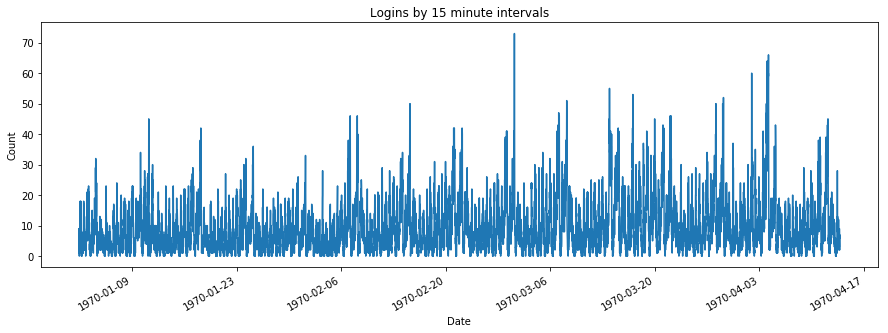

In [32]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(15, 5))
plt.title('Logins by 15 minute intervals')
plt.ylabel('Count')
plt.xlabel('Date')
ax.plot(sorted_times['count'])
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.show()

NameError: name 'mdates' is not defined

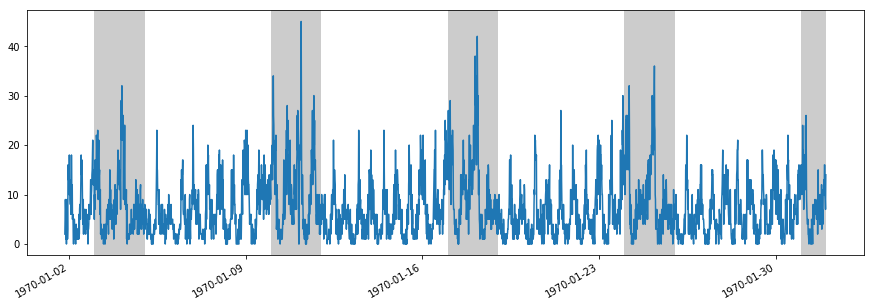

In [33]:
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

def highlight_datetimes(df, indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='gray', edgecolor='none', alpha=.4)
        i += 1
        
groups = sorted_times.groupby(pd.Grouper(freq='M'))
months = pd.DataFrame()
for name, group in groups:
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(group, label=name.month_name())
    weekend_indices = find_weekend_indices(group.index)
    highlight_datetimes(group, weekend_indices, ax)
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
    plt.title('Logins by 15 minute intervals')
    plt.legend(loc='upper right')
    plt.ylabel('Count')
    plt.xlabel('Date')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'WeekdayLocator'

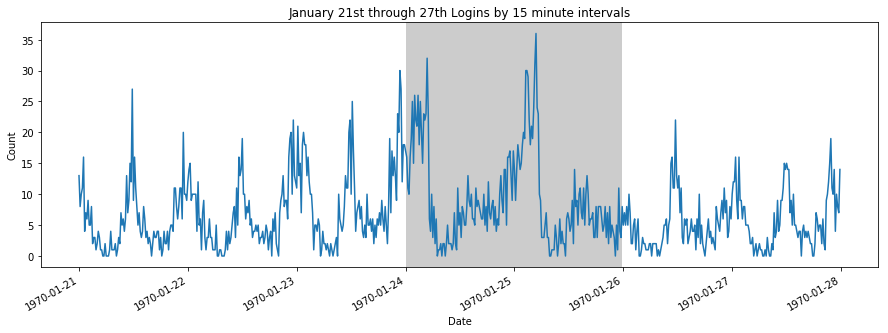

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sorted_times['count'].loc['1970-01-21':'1970-01-27'])
weekend_indices = find_weekend_indices(sorted_times['count'].loc['1970-01-21':'1970-01-27'].index)
highlight_datetimes(sorted_times['count'].loc['1970-01-21':'1970-01-27'], weekend_indices, ax)
plt.title('January 21st through 27th Logins by 15 minute intervals')
plt.ylabel('Count')
plt.xlabel('Date')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(sorted_times.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%a'))
plt.show()

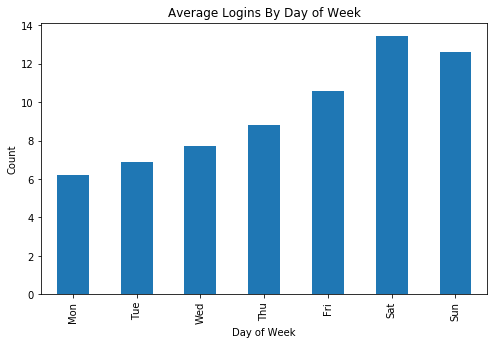

In [41]:
import calendar
fig, ax = plt.subplots(figsize=(8, 5))
sorted_times['weekday'] = sorted_times.index.weekday
dgroups = sorted_times[['count', 'weekday']].groupby('weekday').mean().plot(kind='bar', ax=ax, legend=None)
plt.title('Average Logins By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
labels = (list(calendar.day_abbr))
ax.set_xticklabels(labels)

plt.show()

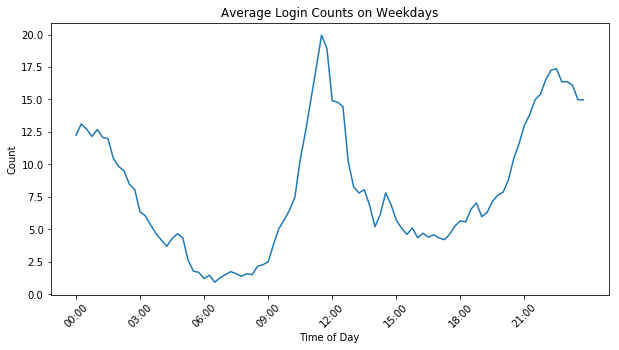

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
sorted_times['time'] = sorted_times.index.time
plot_data = sorted_times[sorted_times['weekday'].isin([0, 1, 2, 3, 4])][['count', 'time']].groupby('time').mean()
ax.plot(plot_data)
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.title('Average Login Counts on Weekdays')
dates_rng = pd.date_range("00:00", "23:59", freq="3H").time
plt.xticks(dates_rng, [dtz.strftime('%H:%M') for dtz in dates_rng], rotation=45)
plt.show()

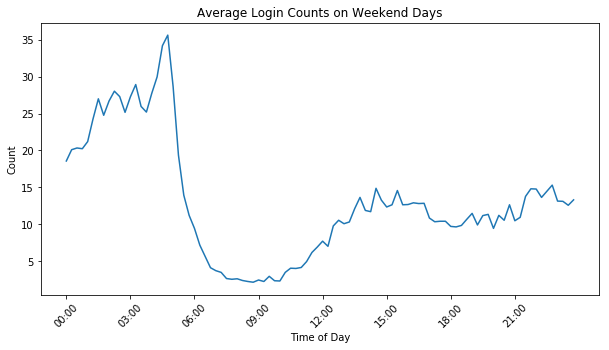

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sorted_times['time'] = sorted_times.index.time
plot_data = sorted_times[sorted_times['weekday'].isin([5, 6])][['count', 'time']].groupby('time').mean()
ax.plot(plot_data)
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.title('Average Login Counts on Weekend Days')
dates_rng = pd.date_range("00:00", "23:59", freq="3H").time
plt.xticks(dates_rng, [dtz.strftime('%H:%M') for dtz in dates_rng], rotation=45)
plt.show()

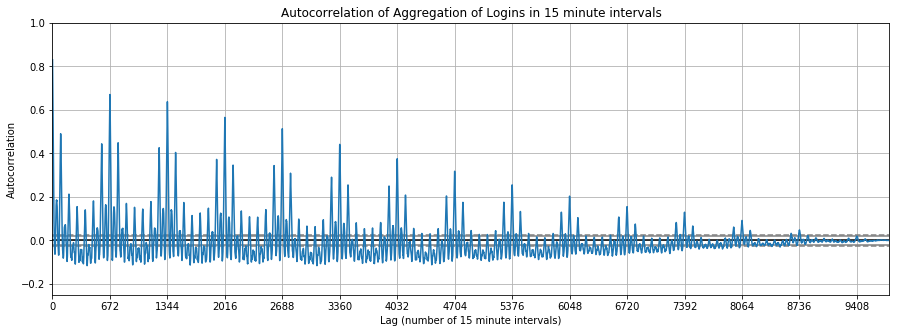

In [45]:
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(15, 5))
autocorrelation_plot(sorted_times['count'])
lag_weeks = [(4*24*7)* x for x in range(0, 15)]
plt.title('Autocorrelation of Aggregation of Logins in 15 minute intervals')
plt.xlabel('Lag (number of 15 minute intervals)')
plt.ylim([-0.25, 1.0])
plt.xticks(lag_weeks)
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
        Source https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Login Count')
    plt.legend(loc="upper left")
    plt.grid(True)

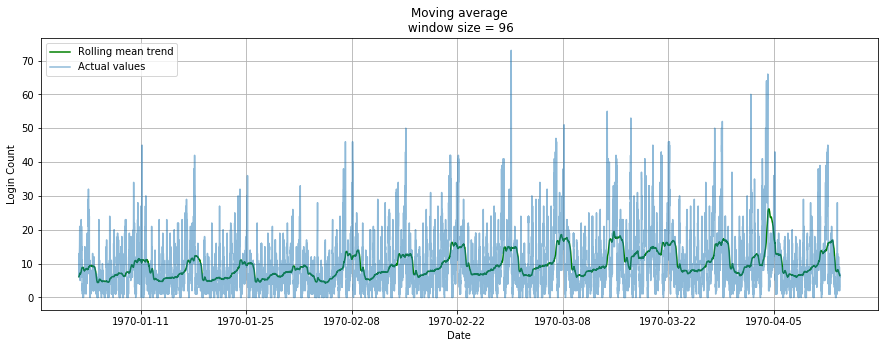

In [48]:
plotMovingAverage(sorted_times['count'], 96) 

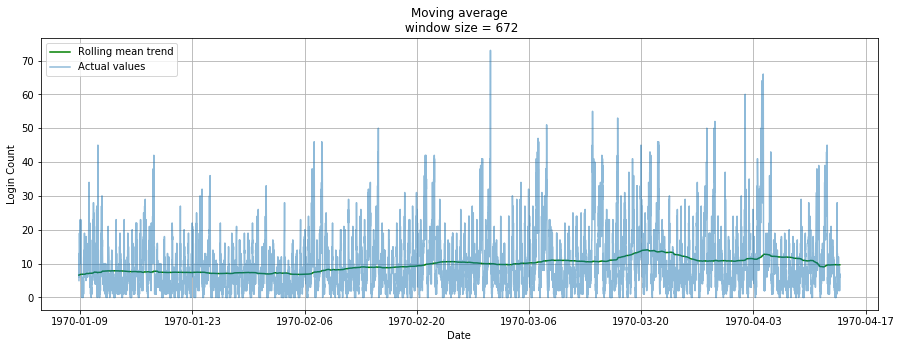

In [50]:
plotMovingAverage(sorted_times['count'], 672) 

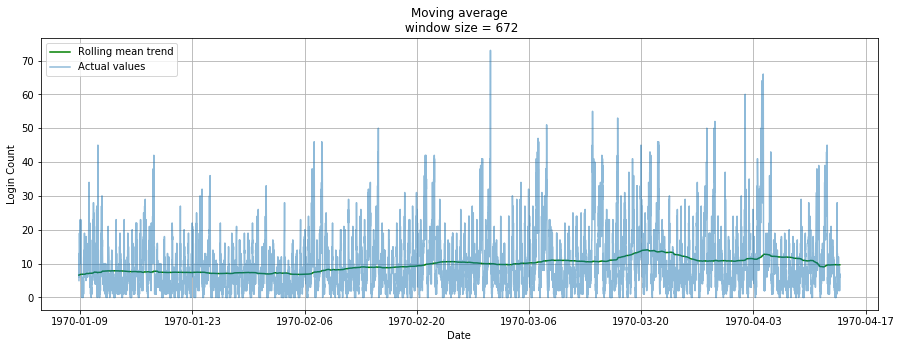

In [11]:
plotMovingAverage(sorted_times['count'], 672) 

Check stationarity of the data.

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    plt.figure(figsize=(15,5))    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'tab:cyan',
                    alpha = 0.7,
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'tab:green', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'tab:brown', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

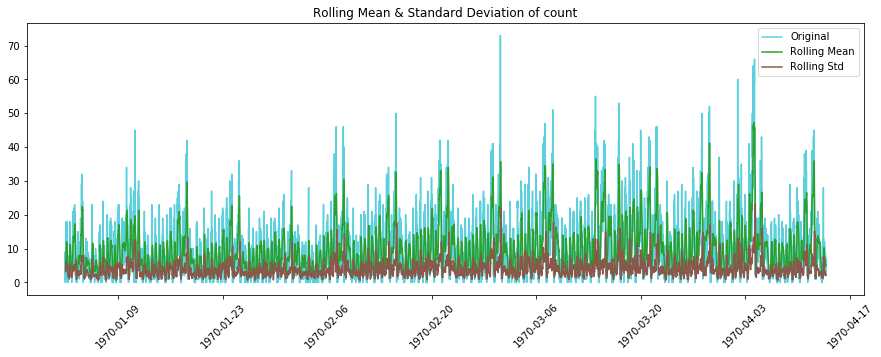

Results of Dickey-Fuller Test:
Test Statistic                -1.033795e+01
p-value                        2.732397e-18
# Lags Used                    3.800000e+01
Number of Observations Used    9.749000e+03
Critical Value (1%)           -3.431021e+00
Critical Value (5%)           -2.861837e+00
Critical Value (10%)          -2.566928e+00
dtype: float64


In [13]:
test_stationarity(df = sorted_times.dropna(), ts = 'count')

Decompose the data into seasonal, trend and residual components.

In [14]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15, 15), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of Login Count', 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

In [22]:
https://stackoverflow.com/questions/42425774/using-statsmodels-seasonal-decompose-without-datetimeindex-but-with-known-freqfrom statsmodels.tsa.seasonal import seasonal_decompose

sorted_times.interpolate(inplace = True)
sorted_times.index=sorted_times.index.to_timestamp()
decomposition = seasonal_decompose(sorted_times)

AttributeError: 'DatetimeIndex' object has no attribute 'to_timestamp'

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sorted_times['count'], model='additive', period = 672)

sorted_times.loc[:,'trend'] = decomposition.trend
sorted_times.loc[:,'seasonal'] = decomposition.seasonal
sorted_times.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = sorted_times, 
                   ts = 'count', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = sorted_times.dropna(), ts = 'residual')

TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

# Part 2 ‑ Experiment & Metrics Design

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would choose 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


# Part 3 ‑ Predictive Modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

In [51]:
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

C:\dev\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'sklearn.experimental'

In [23]:
user_login.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [22]:
display(user_login.shape)
display(user_login.info())
display(user_login.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [25]:
user_login.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


C:\dev\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\dev\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\dev\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\dev\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

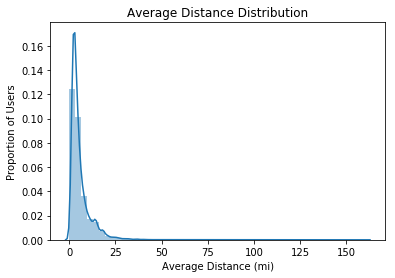

In [26]:
sns.distplot(user_login['avg_dist'])
plt.title('Average Distance Distribution')
plt.xlabel('Average Distance (mi)')
plt.ylabel('Proportion of Users')
plt.show()

In [27]:
user_login[user_login.avg_dist == 0.0]['avg_dist'].count()

150

max of 161 miles in first 30 days is alot. Also avg_dist of 0.0 looks odd.
125 trips in first 30 days is also alot considering the mean. Seems 0.5 miles are recorded as 0.0, this is missing/bad data.

In [28]:
user_login[user_login.avg_dist > 50].sort_values('avg_dist', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
1302,Winterfell,1,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
22290,Astapor,0,2014-01-12,5.0,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.0
47595,King's Landing,0,2014-01-25,5.0,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.0
36625,Astapor,2,2014-01-19,5.0,1.0,2014-01-22,iPhone,0.0,False,100.0,73.88,3.0
22096,Astapor,0,2014-01-17,NaN,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.0
1493,Astapor,1,2014-01-26,5.0,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.0
19197,Astapor,2,2014-01-17,4.7,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.0
42835,Winterfell,0,2014-01-10,5.0,1.0,2014-06-28,Android,0.0,False,100.0,70.48,5.0


There are many users who have 0 trips in first 30 days, yet the average distance of trips in the first 30 days is non-zero. This issue affects almost a third of the dataset

In [30]:
user_login[(user_login['avg_dist'] > 0) & (user_login['trips_in_first_30_days'] == 0)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
13,King's Landing,0,2014-01-29,4.0,1.38,2014-06-08,iPhone,50.0,False,50.0,3.04,5.0
17,King's Landing,0,2014-01-12,3.9,1.00,2014-07-01,iPhone,0.0,True,95.2,2.38,4.8
19,King's Landing,0,2014-01-02,5.0,1.17,2014-06-03,iPhone,33.3,False,66.7,12.08,5.0
22,Winterfell,0,2014-01-24,NaN,1.00,2014-05-02,iPhone,0.0,False,100.0,11.47,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49986,Winterfell,0,2014-01-21,4.0,1.00,2014-05-23,Android,0.0,False,100.0,0.52,5.0
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0


In [31]:
user_login[user_login.trips_in_first_30_days > 45][['avg_dist', 'trips_in_first_30_days']].sort_values('trips_in_first_30_days', 
                                                                                        ascending=False)

,avg_dist,trips_in_first_30_days
18514,2.02,125
99,2.86,73
3030,2.32,71
29070,1.45,63
48804,2.30,58
45489,3.65,56
36917,3.51,56
29043,3.39,55
17942,3.27,55
33488,2.91,54


Before modeling, we need to address the missing/bad data and create target.
1. Null ratings: impute to fill nulls.
2. Null phone types: impute to fill nulls.
3. Bad 0 values in avg_dist, trips_in_first_30_days: change to null then impute to fill nulls.
4. Outliers in avg_surge, trips_in_first_30_days: drop as they are only two users and could significantly affect our model.
5. Target is boolean last_trip_date is in last 30 days of data.

In [34]:
# Leave out the two outliers. 
clean_df = user_login[(user_login.avg_surge < 8)]
clean_df = clean_df[clean_df.trips_in_first_30_days < 125]

In [35]:
user_login.shape, clean_df.shape

((50000, 12), (49998, 12))

In [36]:
clean_df[(clean_df.avg_dist == 0) & (clean_df.trips_in_first_30_days > 0)]['avg_dist'].count()

94

In [37]:
clean_df.loc[((clean_df.avg_dist == 0) & (clean_df.trips_in_first_30_days > 0)), 'avg_dist'] = None

In [38]:
clean_df[(clean_df.avg_dist == 0) & (clean_df.trips_in_first_30_days > 0)]['avg_dist'].count()

0

In [39]:
clean_df[(clean_df.trips_in_first_30_days == 0) & (clean_df.avg_dist > 0)]['trips_in_first_30_days'].count()

15334

In [40]:
clean_df.loc[((clean_df.trips_in_first_30_days == 0) & (clean_df.avg_dist > 0)), 'trips_in_first_30_days'] = None

In [41]:
clean_df[(clean_df.avg_dist == 0) & (clean_df.trips_in_first_30_days > 0)]['avg_dist'].count()

0

Convert categoricals to numeric, dates to days since jan 1 for imputing and modeling.

In [42]:
phone_int = {"Android": 1, "iPhone": 2, None: None}
city_int = {"Astapor": 1, "King\'s Landing": 2, "Winterfell":3}

In [43]:
clean_df['phone_int'] = clean_df.apply(lambda row: phone_int[row['phone']], axis=1)
print('phone_int: \n{}\nphone: \n{}'.format(clean_df['phone_int'].value_counts(), clean_df['phone'].value_counts()))


phone_int: 
2.0    34580
1.0    15022
Name: phone_int, dtype: int64
phone: 
iPhone     34580
Android    15022
Name: phone, dtype: int64


In [44]:
clean_df['city_int'] = clean_df.apply(lambda row: city_int[row['city']], axis=1)
print('city_int: \n{}\ncity: \n{}'.format(clean_df['city_int'].value_counts(), clean_df['city'].value_counts()))

city_int: 
3    23335
1    16534
2    10129
Name: city_int, dtype: int64
city: 
Winterfell        23335
Astapor           16534
King's Landing    10129
Name: city, dtype: int64


In [48]:
from datetime import datetime

jan_1 = datetime.strptime('Jan 1 2014', '%b %d %Y')
clean_df['signup_days_since_jan_1'] = clean_df.apply(lambda row: (row['signup_date'] - jan_1).days, axis=1)
clean_df['last_trip_days_since_jan_1'] = clean_df.apply(lambda row: (row['last_trip_date'] - jan_1).days, axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   city                        49998 non-null  object        
 1   trips_in_first_30_days      34664 non-null  float64       
 2   signup_date                 49998 non-null  datetime64[ns]
 3   avg_rating_of_driver        41876 non-null  float64       
 4   avg_surge                   49998 non-null  float64       
 5   last_trip_date              49998 non-null  datetime64[ns]
 6   phone                       49602 non-null  object        
 7   surge_pct                   49998 non-null  float64       
 8   ultimate_black_user         49998 non-null  bool          
 9   weekday_pct                 49998 non-null  float64       
 10  avg_dist                    49904 non-null  float64       
 11  avg_rating_by_driver        49797 non-null  float64   

data past 7/1/14 should be labled as 'active' for modeling. We're looking for the fraction of users active after 6 months and our signup period begins 1/1/14.

In [50]:
last_date = user_login['last_trip_date'].max()
clean_df['active'] = clean_df.apply(lambda row: (last_date - row['last_trip_date']).days <= 30, axis=1)


users active after 6 months

In [51]:
round(clean_df[clean_df['active']]['active'].count()/clean_df['active'].count(), 3)

0.376

In [52]:
clean_imp = clean_df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'city_int', 
                      'last_trip_days_since_jan_1', 'phone_int', 'signup_days_since_jan_1', 'surge_pct', 
                      'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'active']]

In [53]:
clean_imp.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,weekday_pct
count,49904.000000,49797.000000,41876.000000,49998.000000,49998.000000,49998.000000,49602.000000,49998.000000,49998.000000,34664.000000,49998.000000
mean,5.807822,4.778153,4.601636,1.074624,2.136025,108.335513,1.697149,15.545282,8.847602,3.282483,60.925081
std,5.707266,0.446660,0.617099,0.220173,0.882567,61.717485,0.459496,8.753878,19.955031,4.124249,37.081800
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.430000,4.700000,4.300000,1.000000,1.000000,44.000000,1.000000,8.000000,0.000000,1.000000,33.300000
50%,3.890000,5.000000,4.900000,1.000000,2.000000,127.000000,2.000000,16.000000,0.000000,2.000000,66.700000
75%,6.950000,5.000000,5.000000,1.050000,3.000000,168.000000,2.000000,23.000000,8.600000,4.000000,100.000000
max,160.960000,5.000000,5.000000,5.750000,3.000000,181.000000,2.000000,30.000000,100.000000,73.000000,100.000000


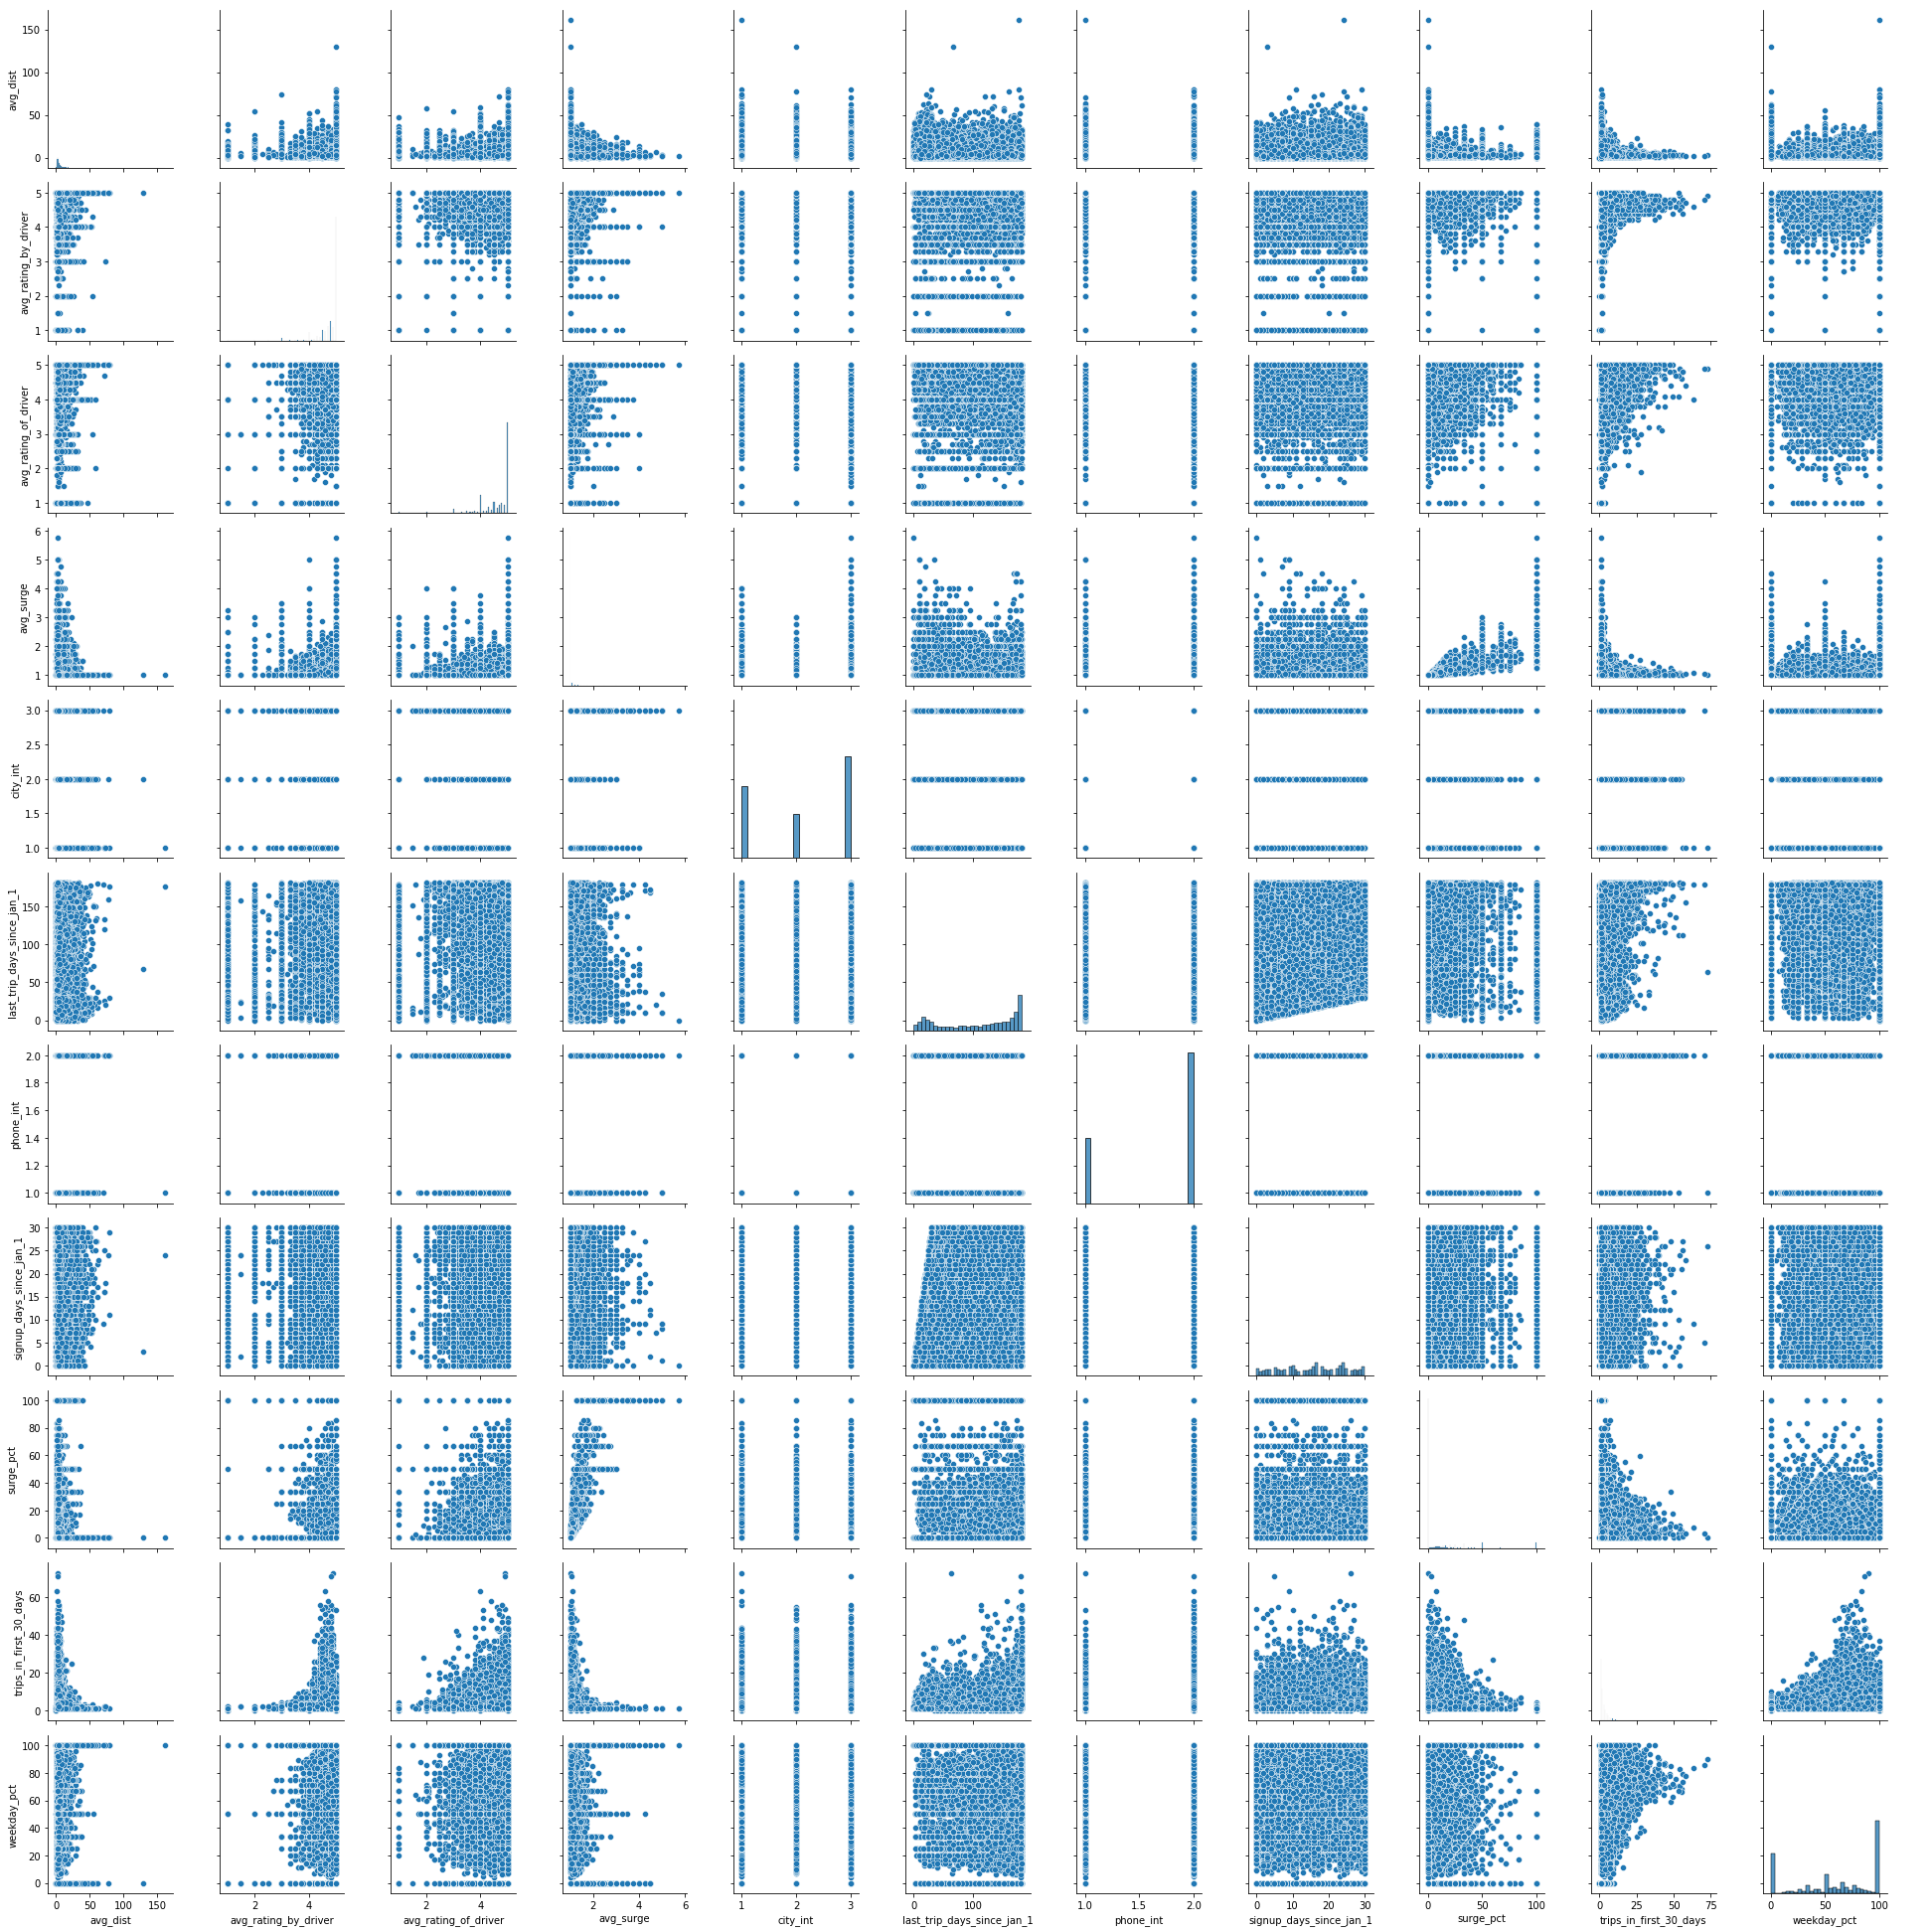

In [54]:
# Drop boolean columns before plotting as they throw errors. 
sns.pairplot(clean_imp.drop(columns=['ultimate_black_user', 'active']))
plt.show()

In [55]:
y = clean_imp['active']
X = clean_imp.drop(columns=['active'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [65]:
pip! install scikitlearn 


The following command must be run outside of the IPython shell:

    $ pip ! install scikitlearn 

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [71]:

pip install scikit-learn


SyntaxError: invalid syntax (<ipython-input-71-9ebc29a662ff>, line 2)

In [66]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(random_state=0)
X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_test_filled = pd.DataFrame(imp.transform(X_test))

ModuleNotFoundError: No module named 'sklearn.experimental'

Convert categorical nominal features to dummies. Drop first as we're using permutation importance which yield bad results with multicollinear features.

In [56]:
X_train_dummy = pd.get_dummies(X_train_filled, columns=['city_int', 'phone_int', 'ultimate_black_user'], drop_first=True)
X_train_dummy.index = X_train.index
X_test_dummy = pd.get_dummies(X_test_filled, columns=['city_int', 'phone_int', 'ultimate_black_user'], drop_first=True)
X_test_dummy.index = X_test.index

NameError: name 'X_train_filled' is not defined

Scale numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cont_cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'last_trip_days_since_jan_1', 
             'signup_days_since_jan_1', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_filled[cont_cols]))
scaled_X_test_cont = pd.DataFrame(scaler.transform(X_test_filled[cont_cols]))
scaled_X_train_cont.columns = cont_cols
scaled_X_train_cont.index = X_train.index
scaled_X_test_cont.columns = cont_cols
scaled_X_test_cont.index = X_test.index

In [ ]:
Concatenate scaled and dummy features into one dataframe.

In [ ]:
#X_train_dummy = X_train_dummy[['city_int_1.0', 'city_int_2.0', 'city_int_3.0', 'phone_int_1.0', 'phone_int_2.0', 
#                               'ultimate_black_user_0.0', 'ultimate_black_user_1.0']]
#X_test_dummy = X_test_dummy[['city_int_1.0', 'city_int_2.0', 'city_int_3.0', 'phone_int_1.0', 'phone_int_2.0', 
#                             'ultimate_black_user_0.0', 'ultimate_black_user_1.0']]
X_train_dummy = X_train_dummy[['city_int_2.0', 'city_int_3.0', 'phone_int_2.0', 'ultimate_black_user_1.0']]
X_test_dummy = X_test_dummy[['city_int_2.0', 'city_int_3.0', 'phone_int_2.0', 'ultimate_black_user_1.0']]
X_train_processed = pd.concat([scaled_X_train_cont, X_train_dummy],axis='columns')
X_test_processed = pd.concat([scaled_X_test_cont, X_test_dummy],axis='columns')

In [ ]:
X_train_dummy.head()

Look at feature correlation with target and other features.

In [52]:
# calculate the correlation matrix of the processed data. 
corr_df = pd.concat([X_train_processed, y_train], axis=1)
corr = corr_df.corr()

# plot the heatmap
fig = plt.figure(figsize=(8, 8)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Correlation heatmap of features and target')
plt.show()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000


# Modeling Building

Logistics Regression Model

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

C:\dev\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\dev\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [75]:
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced').fit(X_train_processed, y_train)
print('Test accuracy with default hyperparameters: {}'.format(accuracy_score(clf.predict(X_test_processed), y_test)))

NameError: name 'X_train_processed' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced')

# define parameter values
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.001]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_processed, y_train)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")
model = grid_search.best_estimator_
y_pred = model.predict(X_test_processed)
print('Best score on test data: {}'.format(accuracy_score(y_pred, y_test)))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Not Active', 'Active']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_df(clf, X_test, y_test, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for binary model supporting .decision_function().
    
    Input: 
        clf: Trained  binary Classifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        figsize: Figure size of plot, optional
    """
    y_score = clf.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1.0)
    roc_auc = auc(fpr, tpr)

    # plot roc 
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    ax.plot(fpr, tpr, label='ROC area = %0.2f' % (roc_auc))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_roc_df(model, X_test_processed, y_test, figsize=(6, 6))

In [ ]:
from sklearn.inspection import permutation_importance

def plot_top_features(clf, X, y, feature_names):
    """
    Plot feature importance of a classifier by permuting one feature at a time and measuring decrease in score. 
    Most important features will cause biggest change in performance. 
    
    Input:
            clf:             classifier 
            X_train:         feature set, np.array
            y_train:         target labels, np.array
            feature_names:   list of feature names
    """
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[perm_sorted_idx])
    ax.set_title('Permutation Feature Importance')
    ax.set_xlabel('Decrease in model score after permuting feature')
    fig.tight_layout()
    plt.show()

    

X_train_processed_df = pd.concat([scaled_X_train_cont, X_train_dummy],axis='columns').drop(columns=['last_trip_days_since_jan_1', 
                                                                                             'avg_surge'])
feature_names = X_train_processed_df.columns
plot_top_features(model, X_train_processed, y_train, feature_names)

Support Vector Machine

In [ ]:
svm = SVC(random_state=0, class_weight='balanced')
svm.fit(X_train_processed, y_train)
print('Test accuracy with default hyperparameters: {}'.format(accuracy_score(svm.predict(X_test_processed), y_test)))

In [ ]:
from sklearn.model_selection import GridSearchCV

model = SVC(random_state=0, class_weight='balanced')

# define parameter values
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
c_values = [200, 100, 10, 1]

# define grid search
grid = dict(C=c_values, kernel=kernels)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_processed, y_train)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")
model = grid_search.best_estimator_
y_pred = model.predict(X_test_processed)
print('Best score on test data: {}'.format(accuracy_score(y_pred, y_test)))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Not Active', 'Active']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
plot_roc_df(model, X_test_processed, y_test, figsize=(6, 6))

In [ ]:
plot_top_features(model, X_test_processed, y_test, feature_names)

Gradiant Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grd = GradientBoostingClassifier(random_state=42)
grd.fit(X_train_processed, y_train)
print('Test accuracy with default hyperparameters: {}'.format(accuracy_score(grd.predict(X_test_processed), y_test)))

# 3. Question
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention 

# Notes 

In [6]:
user_login['last_trip_date'].describe()

C:\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [11]:
retained = (user_login.last_trip_date >= '2014-06-01').sum() / (user_login.last_trip_date >= '2014-06-01').count()
retained    

0.37608

In [12]:
user_login['retained'] = (user_login.last_trip_date >= '2014-06-01')*1
user_login.describe()     

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


Look at which features are highest correlated with retained riders (those who took a ride in the first six months of the year).

Summary: 

in order to fully correlate the data, we need to change city, and phone to numerical features. I would do a one hot encoding or create dummy variables


In [15]:
#create dummy variables for categorical variables 
#select all the columns that are categorical, ‘object’, creating a data frame subset 
dummy = pd.get_dummies(user_login['city'])
dummy2 = pd.get_dummies(user_login['phone'])

In [16]:
dummy.head()

,Astapor,King's Landing,Winterfell
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,1


In [17]:
dummy2.head()

,Android,iPhone
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0


In [18]:
#concatenate the original data frame df 
#Concat new columns to original dataframe 
df_concat = pd.concat([user_login, dummy2, dummy], axis=1)
print (df_concat.head())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  Android  iPhone  \
0         46.2 

In [19]:
#Drop corresponding categorical columns and first dummy variable columns.

df_concat.drop(['city','phone'], inplace=True, axis=1)
print(df_concat.head())

   trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0     2014-06-17       15.4                 True         46.2      3.67   
1     2014-05-05        0.0                False         50.0      8.26   
2     2014-01-07        0.0                False        100.0      0.77   
3     2014-06-29       20.0                 True         80.0      2.36   
4     2014-03-15       11.8                False         82.4      3.13   

   avg_rating_by_driver  retained  Android  iPhone  Astapor  King's Landing  \
0                   5.0  

In [20]:
#check info on data to check categorical variables are gone.

df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  bool          
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    49799 non-null  float64       
 10  retained                50000 non-null  int32         
 11  Android                 50000 non-null  uint8         
 12  iPhone                  50000 non-null  uint8 

In [21]:
# saving the new dataframe
df_concat.to_csv('concat_user_info.csv')

In [23]:
df_concat.corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Android,iPhone,Astapor,King's Landing,Winterfell
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115,0.210463,-0.059309,0.058342,-0.061075,0.024650,0.037735
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175,-0.011653,0.026729,-0.026864,0.032699,0.088392,-0.103100
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597,-0.003333,-0.008977,0.011104,0.037172,-0.009198,-0.027643
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103,0.011797,-0.010150,0.012851,0.045457,0.028221,-0.065603
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343,0.205002,-0.075836,0.067002,0.021259,0.039649,-0.051990
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442,0.009693,-0.009241,0.006726,-0.010540,0.031349,-0.015318
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540,-0.092780,0.020888,-0.025030,-0.045431,0.015877,0.030050
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000,-0.026791,0.008783,-0.010148,0.032580,0.084648,-0.098929
retained,0.210463,-0.011653,-0.003333,0.011797,0.205002,0.009693,-0.092780,-0.026791,1.000000,-0.225464,0.225244,-0.174655,0.262284,-0.046611
Android,-0.059309,0.026729,-0.008977,-0.010150,-0.075836,-0.009241,0.020888,0.008783,-0.225464,1.000000,-0.981471,0.025642,-0.059203,0.023517


In [28]:
df_concat.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,Android,iPhone,Astapor,King's Landing,Winterfell
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080,0.300440,0.691640,0.330680,0.202600,0.466720
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405,0.458454,0.461821,0.470463,0.401941,0.498896
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Concerning riders place of origin, 33% are from Astapor, 20% are from King's Landing, and 46% Winterfell. Regarding phones, about 70% of users use an iPhone, and 30% use Android.

Now lets see the correlation with all of the features. 

Whats the correlation between those retained other features. This will put put us in the right direction to predict future rider retention.

In [30]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
King's Landing            0.262284
iPhone                    0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
Winterfell               -0.046611
avg_dist                 -0.092780
Astapor                  -0.174655
Android                  -0.225464
Name: retained, dtype: float64

It seems there is a high correlation with being retained and being from kings landing and having an iphone, andultimate_black_user. There is a negative correlation with being from Astapor or Winterfell or using an Android and being retained.

were missing the correlation with the two date columns, so we need to encode them numerically and change and the date columns to the number of days into 2014.